In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import my_speller
import imp
imp.reload(my_speller)
from autocorrect import spell as spell_eng

In [23]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
df1 = pd.read_csv('sdf.csv')

In [3]:
df1.head()

,REQ_NUM,INITIATOR_TYPE,MESSAGE
0,1704120255467501,System,Вашему вопросу присвоен номер #num
1,1704120255467501,Operator,Здравствуйте !
2,1704120255467501,Client,"Я внес деньги на карту . Когда они придут , я ..."
3,1704120255467501,Operator,Вы вносили деньги на дебетовую карту или на кр...
4,1704120255467501,Client,Кредитная


In [4]:
df2 = pd.read_csv('sdf2.csv')

In [5]:
df2.head()

,CHAT_ID,CHAT_STEP,EV_STEP,MESSAGE_OPERATOR,MESSAGE_CLIENT
0,1-312KFA7K,1,1,Чем могу помочь ?,NaN
1,1-312KFA7K,1,0,"Здравствуйте , #Name !",NaN
2,1-312L9W2Y,1,0,"Здравствуйте , #Name !",NaN
3,1-312L9W2Y,1,1,Чем могу вам помочь ?,NaN
4,1-312L9W2Y,2,0,Оба счета открыты в пределах одного региона ?,"Здравствуйте , какой процент удерживается в ка..."


* Для кого автозаполнение: клиенты, система, операторы, какие-то два из них, все?
* Посмотреть на содержимое, выявить уникальные
* Убрать знаки препинания
* Убрать цифры
* Выявить биграммы
* Посчитать для каждого слова количество упоминаний остальных слов после него
* Определить, сколько верхних значений берем
* Определить, как выкидывать редкие пары (тупо счетчик или что-то поинтереснее)

In [50]:
CV = CountVectorizer(ngram_range=(2,2))

Модуль исправления ошибок

In [7]:
fn_dict = 'data/word_freq_dict.csv.zip'
fn_letters = 'data/letter_typos_matrix.json'
fn_typical = 'data/typical_typos.json'
fn_bigrams = 'data/bigrams.zip'
speller = my_speller.Speller(fn_dict, fn_letters, fn_typical, fn_bigrams, fix_register=True, verbose=True, try_split=True)

In [22]:
%%time
speller('прилажение для adroid')


got 1 candidate for "прилажение": приложение
word для is known
Wall time: 3 ms


'приложение для adroid'

In [30]:
spell_eng('adroid application')

'adroid application'

In [36]:
spell_eng('feel teh powar of')

'feel teh powar of'

In [48]:
spell_eng('teh')

'Teh'

In [51]:
%%time
client_mess = pd.concat([df1[df1.INITIATOR_TYPE=='Client'].MESSAGE, df2.MESSAGE_CLIENT])
regex = re.compile('\d+|_+')
cnt = CV.fit_transform(client_mess.dropna().replace(regex, ' '))

Wall time: 32.2 s


In [52]:
%%time
# Все биграммы
features = CV.get_feature_names()
# Суммарное упоминание каждой биграммы во всех документах
total_count = np.array(np.sum(cnt, axis=0))

Wall time: 1.76 s


In [53]:
%%time
# Поделим биграммы на первое и второе слово
first_word = [x.split(' ')[0] for x in features]
second_word = [x.split(' ')[1] for x in features]

Wall time: 1.45 s


In [78]:
word_freq

['aa inflight',
 'aaa tolko',
 'aaaa bb',
 'aarbekovich date',
 'ab dnb',
 'aba number',
 'aba или',
 'abdaily когда',
 'abdukarim email',
 'abdukarim num',
 'abdv abw',
 'able to',
 'aboccnbj num',
 'aboccnbj без',
 'about credit',
 'about my',
 'about pesio',
 'about receivig',
 'about the',
 'about this',
 'about visa',
 'about yourself',
 'abrat omer',
 'abroad ow',
 'abshatse nesmojhem',
 'abuichno parol',
 'abuladze ame',
 'abuladze is',
 'abuladzebirth date',
 'abw ваш',
 'acba credit',
 'acc num',
 'accept solutions',
 'acceptace rus',
 'access messages',
 'access the',
 'account amp',
 'account holder',
 'account iban',
 'account in',
 'account lt',
 'account my',
 'account name',
 'account num',
 'account number',
 'account still',
 'account terminal',
 'account type',
 'account адрес',
 'account должен',
 'accounts or',
 'accout ad',
 'accout ame',
 'accout bak',
 'accout balace',
 'accout blocked',
 'accout but',
 'accout holder',
 'accout iban',
 'accout is',
 'accout no',

## Датафрейм с парами слов и количеством появлений

In [54]:
w = pd.DataFrame({'first_word':first_word, 'second_word':second_word, 'count':total_count.reshape(-1)})

In [55]:
w.head()

,count,first_word,second_word
0,1,aa,inflight
1,1,aaa,tolko
2,2,aaaa,bb
3,1,aarbekovich,date
4,1,ab,dnb


### Найдём для каждого слова 3 наиболее популярных слова после него. Для этого сгруппируем датафрейм по первому слову и подсчитаем агрегатными функциями 3 максимальных значения в каждой группе

In [56]:
# Функции для подсчета второго и третьего среди максимальных значений
def top2(x):
    s = np.sort(x)
    if s.shape[0]>1:
        return s[-2]
    else:
        return None
def top3(x):
    s = np.sort(x)
    if s.shape[0]>2:
        return s[-3]
    else:
        return None

In [74]:
gb = w.groupby(['first_word']).aggregate({'count':[np.max, top2, top3], 'second_word': lambda x: x})

In [75]:
gb.head()

count           second_word
             amax top2 top3    <lambda>
first_word                             
aa              1  NaN  NaN    inflight
aaa             1  NaN  NaN       tolko
aaaa            2  NaN  NaN          bb
aarbekovich     1  NaN  NaN        date
ab              1  NaN  NaN         dnb

In [59]:
gb[gb['count']['amax']>20].to_csv('most_frequent.csv', encoding='Windows-1251')

<module 'matplotlib.pyplot' from 'C:\\Users\\andrey\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

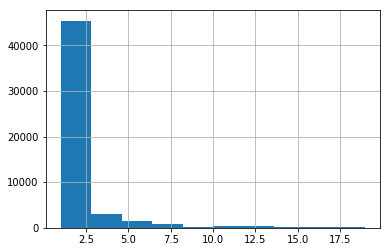

In [96]:
gb[gb['count']['amax']<20]['count']['amax'].hist(bins=10)
plt

In [72]:
np.sort([1,3,2])

array([1, 2, 3])

In [76]:
w[w.first_word == 'сбербанк'][w['count']>100]

C:\Users\andrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,first_word,second_word
761519,546,сбербанк,name
762078,106,сбербанк,как
762232,128,сбербанк,мне
762286,360,сбербанк,на
762334,253,сбербанк,не
762366,120,сбербанк,но
762460,133,сбербанк,он
762471,104,сбербанк,онлай
762474,11213,сбербанк,онлайн
762826,399,сбербанк,премьер


In [77]:
gb.loc['сбербанк']

count        amax        11213
             top2          546
             top3          399
second_word  <lambda>       []
Name: сбербанк, dtype: object

In [70]:
speller('сбербанк онлай')

word сбербанк is known
онлай                -> ондай               : p_aprior_adj = 0.0000000, p_typo_adj = 0.0304897, p_word = 0.00000000062
онлай                -> облай               : p_aprior_adj = 0.0000000, p_typo_adj = 0.0005855, p_word = 0.00000000002
онлай                -> онлайн              : p_aprior_adj = 0.0000280, p_typo_adj = 0.0221511, p_word = 0.00000062110
онлай                -> олай                : p_aprior_adj = 0.0000000, p_typo_adj = 0.0207694, p_word = 0.00000000042
got several candidates for "онлай": [(1.0, 'онлайн'), (0.0009955146722182586, 'ондай'), (0.0006781374808288217, 'олай'), (3.567633628133112e-05, 'облай')]


'Сбербанк онлайн'

In [79]:
w1 = w.set_index([w['first_word'], w['count']])

In [81]:
w1.head(40)

count     first_word second_word
first_word    count                                  
aa            1          1             aa    inflight
aaa           1          1            aaa       tolko
aaaa          2          2           aaaa          bb
aarbekovich   1          1    aarbekovich        date
ab            1          1             ab         dnb
aba           2          2            aba      number
              2          2            aba         или
abdaily       1          1        abdaily       когда
abdukarim     1          1      abdukarim       email
              1          1      abdukarim         num
abdv          1          1           abdv         abw
able          1          1           able          to
aboccnbj      1          1       aboccnbj         num
              1          1       aboccnbj         без
about         1          1          about      credit
              3          3          about          my
              1          1          about       pesio
              2          2          about    receivig
              1          1          about         the
              1          1          about        this
              1          1          about        visa
              1          1          about    yourself
abrat         1          1          abrat        omer
abroad        1          1         abroad          ow
abshatse      1          1       abshatse   nesmojhem
abuichno      1          1       abuichno       parol
abuladze      2          2       abuladze         ame
              1          1       abuladze          is
abuladzebirth 2          2  abuladzebirth        date
abw           1          1            abw         ваш
acba          2          2           acba      credit
acc           1          1            acc         num
accept        1          1         accept   solutions
acceptace     2          2      acceptace         rus
access        1          1         access    messages
              1          1         access         the
account       1          1        account         amp
              1          1        account      holder
              1          1        account        iban
              1          1        account          in

In [84]:
w1.loc[(slice(gb.index), slice(gb['count']['amax'])), 'second_word']

UnsortedIndexError: 'MultiIndex Slicing requires the index to be fully lexsorted tuple len (2), lexsort depth (1)'

In [85]:
G = w.sort_values(['first_word', 'count'], ascending=False).groupby(['first_word']).cumcount()

In [86]:
G

963648    0
963647    0
963646    0
963644    0
963645    1
963642    0
963643    1
963641    0
963638    0
963639    1
963640    2
963637    0
963636    1
963635    0
963634    0
963633    0
963632    0
963631    0
963629    0
963630    1
963628    0
963627    0
963626    0
963625    0
963624    0
963622    0
963623    1
963615    0
963606    1
963607    2
         ..
29        0
28        0
26        0
27        1
25        0
24        0
23        0
22        0
15        0
17        1
14        2
16        3
18        4
19        5
20        6
21        7
12        0
13        1
11        0
10        0
8         0
9         1
7         0
5         0
6         1
4         0
3         0
2         0
1         0
0         0
Length: 963649, dtype: int64

In [88]:
w.head(60)

,count,first_word,second_word
0,1,aa,inflight
1,1,aaa,tolko
2,2,aaaa,bb
3,1,aarbekovich,date
4,1,ab,dnb
5,2,aba,number
6,2,aba,или
7,1,abdaily,когда
8,1,abdukarim,email
9,1,abdukarim,num


In [89]:
G1 = pd.concat([w, G], axis=1)

In [91]:
G1.sort_values(['first_word', 'count'], ascending=False, inplace=True)

In [93]:
G1.tail(60)

,count,first_word,second_word,0
62,1,accout,numbeeficiary,15
64,1,accout,numtoday,16
65,1,accout,or,17
66,1,accout,please,18
67,1,accout,privyaza,19
68,1,accout,provided,20
70,1,accout,th,21
73,1,accout,with,22
74,1,accout,неправильно,23
50,1,accounts,or,0
